# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import gc
import matplotlib.pyplot as plt
import optuna
from optuna.integration import LightGBMPruningCallback
from verstack import LGBMTuner
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
import lightgbm as lgbm

# Importing datasets

In [2]:
application_test_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\application_test.csv')
application_train_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\application_train.csv')
bureau_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\bureau.csv')
bureau_balance_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\bureau_balance.csv')
credit_card_balance_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\credit_card_balance.csv')
installments_payments_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\installments_payments.csv')
POS_CASH_balance_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\POS_CASH_balance.csv')
previous_application_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\previous_application.csv')
sample_submission_df = pd.read_csv('C:\\Users\\Omar Atef\\Desktop\\My Files\\home-credit-default-risk\\sample_submission.csv')

# Exploring the datasets

In [3]:
pd.set_option("display.max_columns", None)
application_train_df.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
pd.set_option("display.max_columns", None)
application_test_df.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [5]:
pd.set_option("display.max_columns", None)
bureau_df.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
application_train_df['NAME_FAMILY_STATUS'].value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [7]:
bureau_df['CREDIT_DAY_OVERDUE'].value_counts()

0       1712211
30          311
60          126
8           103
13          103
         ...   
1445          1
278           1
707           1
2193          1
1931          1
Name: CREDIT_DAY_OVERDUE, Length: 942, dtype: int64

In [8]:
list(application_train_df.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [9]:
# removing unnecessary columns from the dataset, leaving only the ones of relatively high importance

pd.set_option("display.max_columns", None)
application_df = application_train_df[['SK_ID_CURR', 'CODE_GENDER','TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION']]
application_df.head(5)

,SK_ID_CURR,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_ID_PUBLISH,DAYS_REGISTRATION
0,100002,M,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,NaN,1,1,0,1,1,0,Laborers,1.0,0.083037,0.262949,0.139376,-2120,-3648.0
1,100003,F,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,-16765,-1188,NaN,1,1,0,1,1,0,Core staff,2.0,0.311267,0.622246,NaN,-291,-1186.0
2,100004,M,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,26.0,1,1,1,1,1,0,Laborers,1.0,NaN,0.555912,0.729567,-2531,-4260.0
3,100006,F,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039,NaN,1,1,0,1,0,0,Laborers,2.0,NaN,0.650442,NaN,-2437,-9833.0
4,100007,M,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038,NaN,1,1,0,1,0,0,Core staff,1.0,NaN,0.322738,NaN,-3458,-4311.0


In [10]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SK_ID_CURR           307511 non-null  int64  
 1   CODE_GENDER          307511 non-null  object 
 2   TARGET               307511 non-null  int64  
 3   NAME_CONTRACT_TYPE   307511 non-null  object 
 4   FLAG_OWN_CAR         307511 non-null  object 
 5   FLAG_OWN_REALTY      307511 non-null  object 
 6   CNT_CHILDREN         307511 non-null  int64  
 7   AMT_INCOME_TOTAL     307511 non-null  float64
 8   AMT_CREDIT           307511 non-null  float64
 9   AMT_ANNUITY          307499 non-null  float64
 10  AMT_GOODS_PRICE      307233 non-null  float64
 11  NAME_INCOME_TYPE     307511 non-null  object 
 12  NAME_EDUCATION_TYPE  307511 non-null  object 
 13  NAME_FAMILY_STATUS   307511 non-null  object 
 14  NAME_HOUSING_TYPE    307511 non-null  object 
 15  DAYS_BIRTH       

In [11]:
application_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_ID_PUBLISH,DAYS_REGISTRATION
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,-16036.995067,63815.045904,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,0.502130,5.143927e-01,0.510853,-2994.202373,-4986.120328
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,4363.988632,141275.766519,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.211062,1.910602e-01,0.194844,1509.450419,3522.886321
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-25229.000000,-17912.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,-7197.000000,-24672.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,-19682.000000,-2760.000000,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.334007,3.924574e-01,0.370650,-4299.000000,-7479.500000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,-15750.000000,-1213.000000,9.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.505998,5.659614e-01,0.535276,-3254.000000,-4504.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,-12413.000000,-289.000000,15.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.675053,6.636171e-01,0.669057,-1720.000000,-2010.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,-7489.000000,365243.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,0.962693,8.549997e-01,0.896010,0.000000,0.000000


0    282686
1     24825
Name: TARGET, dtype: int64


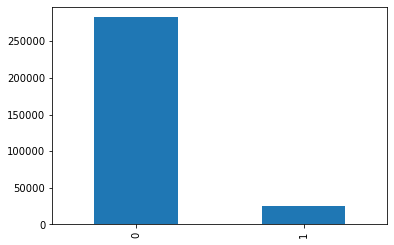

In [12]:
application_df['TARGET'].value_counts().plot(kind='bar')
print(application_df['TARGET'].value_counts())

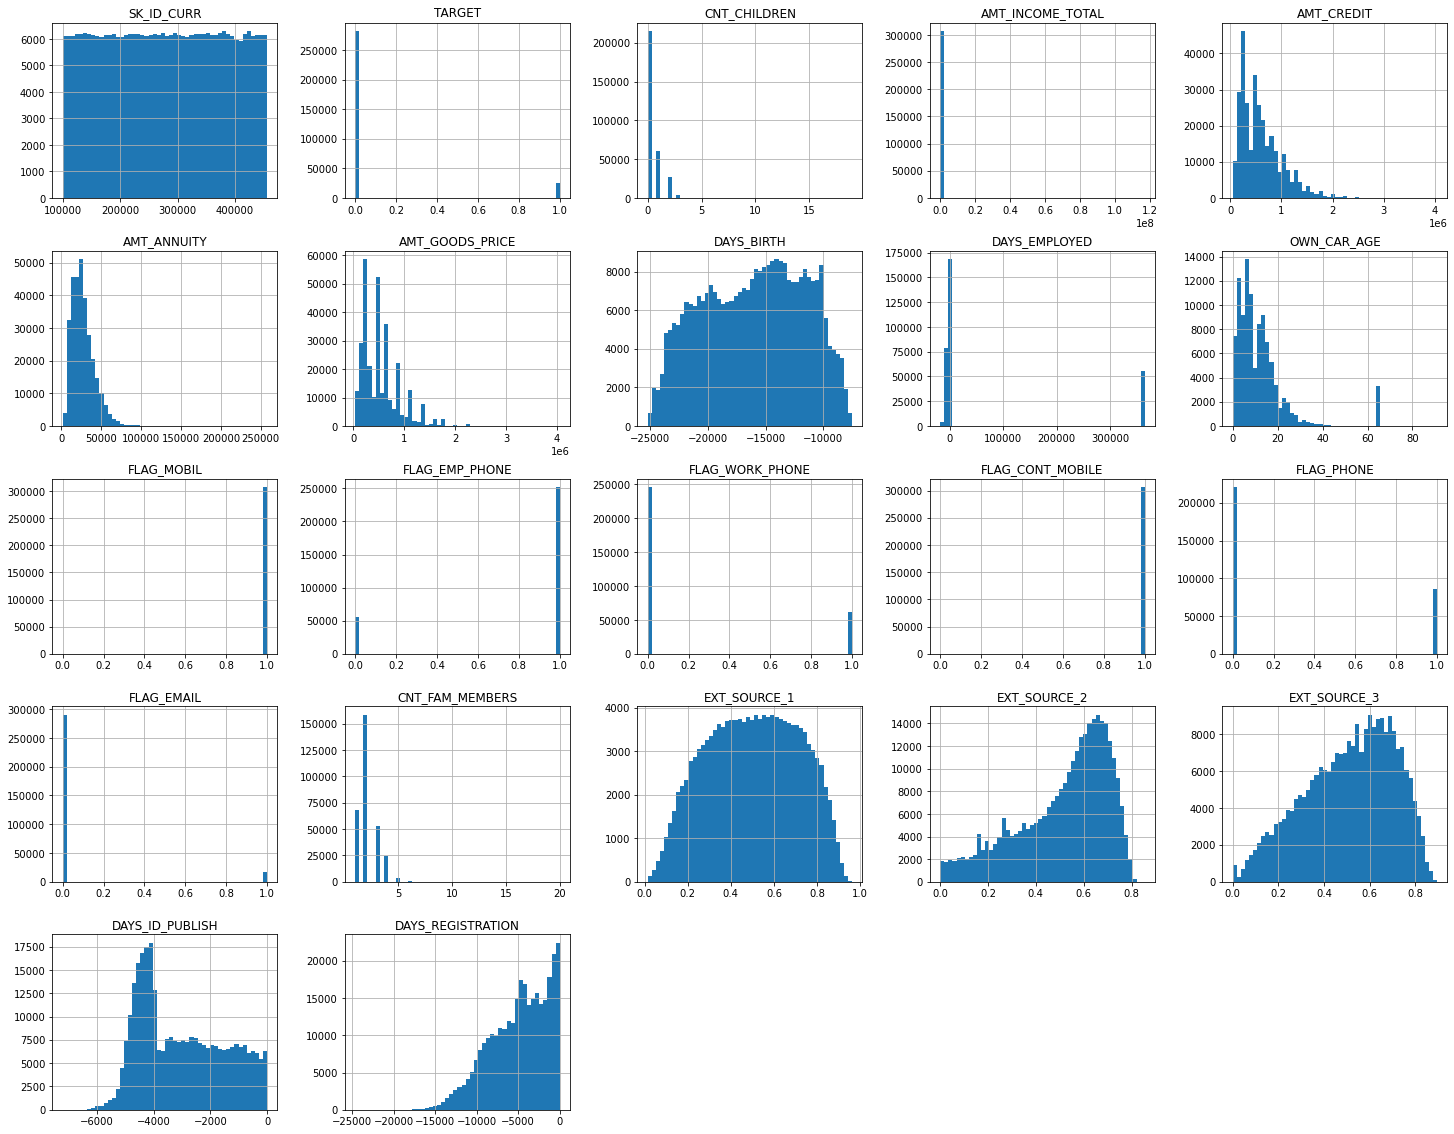

In [13]:
application_df.hist(bins=50,figsize=(25,20))
plt.show()

In [14]:
application_df.loc[application_df['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243], dtype=int64)

In [15]:
application_df['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [16]:
application_df.replace([np.inf, -np.inf], np.nan, inplace=True)
application_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
application_df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
#application_df.replace(np.nan, 0, inplace=True)
pd.set_option("display.max_columns", None)
application_df

,SK_ID_CURR,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_ID_PUBLISH,DAYS_REGISTRATION
0,100002,M,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637.0,NaN,1,1,0,1,1,0,Laborers,1.0,0.083037,0.262949,0.139376,-2120,-3648.0
1,100003,F,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,-16765,-1188.0,NaN,1,1,0,1,1,0,Core staff,2.0,0.311267,0.622246,NaN,-291,-1186.0
2,100004,M,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225.0,26.0,1,1,1,1,1,0,Laborers,1.0,NaN,0.555912,0.729567,-2531,-4260.0
3,100006,F,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039.0,NaN,1,1,0,1,0,0,Laborers,2.0,NaN,0.650442,NaN,-2437,-9833.0
4,100007,M,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038.0,NaN,1,1,0,1,0,0,Core staff,1.0,NaN,0.322738,NaN,-3458,-4311.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,M,0,Cash loans,N,N,0,157500.0,254700.0,27558.0,225000.0,Working,Secondary / secondary special,Separated,With parents,-9327,-236.0,NaN,1,1,0,1,0,0,Sales staff,1.0,0.145570,0.681632,NaN,-1982,-8456.0
307507,456252,F,0,Cash loans,N,Y,0,72000.0,269550.0,12001.5,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20775,NaN,NaN,1,0,0,1,1,0,NaN,1.0,NaN,0.115992,NaN,-4090,-4388.0
307508,456253,F,0,Cash loans,N,Y,0,153000.0,677664.0,29979.0,585000.0,Working,Higher education,Separated,House / apartment,-14966,-7921.0,NaN,1,1,0,1,0,1,Managers,1.0,0.744026,0.535722,0.218859,-5150,-6737.0
307509,456254,F,1,Cash loans,N,Y,0,171000.0,370107.0,20205.0,319500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-11961,-4786.0,NaN,1,1,0,1,0,0,Laborers,2.0,NaN,0.514163,0.661024,-931,-2562.0


In [17]:
application_df['AGE'] = (application_df['DAYS_BIRTH'] / -365)
application_df.drop(['DAYS_BIRTH'], axis=1, inplace=True)

application_df['ID_PUBLISH_YEARS'] = (application_df['DAYS_ID_PUBLISH'] / -365)
application_df.drop(['DAYS_ID_PUBLISH'], axis=1, inplace=True)

application_df['EMPLOYED_YEARS'] = (application_df['DAYS_EMPLOYED'] / -365)
application_df.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)

application_df['REGISTRATION_YEARS'] = (application_df['DAYS_REGISTRATION'] / -365)
application_df.drop(['DAYS_REGISTRATION'], axis=1, inplace=True)

In [18]:
application_df.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'TARGET', 'NAME_CONTRACT_TYPE',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'AGE', 'ID_PUBLISH_YEARS', 'EMPLOYED_YEARS', 'REGISTRATION_YEARS'],
      dtype='object')

In [19]:
# making sure SK_IDs are unique

application_df[application_df['SK_ID_CURR'].duplicated()].value_counts()

Series([], dtype: int64)

In [20]:
bureau_df.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [21]:
bureau_balance_df.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [22]:
pd.set_option("display.max_columns", None)
POS_CASH_balance_df.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [23]:
credit_card_balance_df.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


# Pre-processing

In [24]:
# checking correlation between columns
cor_matrix = application_df.corr()['TARGET'].sort_values()
print(cor_matrix)

EXT_SOURCE_3         -0.178919
EXT_SOURCE_2         -0.160472
EXT_SOURCE_1         -0.155317
AGE                  -0.078239
EMPLOYED_YEARS       -0.074958
ID_PUBLISH_YEARS     -0.051457
REGISTRATION_YEARS   -0.041975
AMT_GOODS_PRICE      -0.039645
AMT_CREDIT           -0.030369
FLAG_PHONE           -0.023806
AMT_ANNUITY          -0.012817
AMT_INCOME_TOTAL     -0.003982
SK_ID_CURR           -0.002108
FLAG_EMAIL           -0.001758
FLAG_CONT_MOBILE      0.000370
FLAG_MOBIL            0.000534
CNT_FAM_MEMBERS       0.009308
CNT_CHILDREN          0.019187
FLAG_WORK_PHONE       0.028524
OWN_CAR_AGE           0.037612
FLAG_EMP_PHONE        0.045982
TARGET                1.000000
Name: TARGET, dtype: float64


In [25]:
pd.set_option("display.max_columns", None)
application_df

,SK_ID_CURR,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,ID_PUBLISH_YEARS,EMPLOYED_YEARS,REGISTRATION_YEARS
0,100002,M,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,1,1,0,1,1,0,Laborers,1.0,0.083037,0.262949,0.139376,25.920548,5.808219,1.745205,9.994521
1,100003,F,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,NaN,1,1,0,1,1,0,Core staff,2.0,0.311267,0.622246,NaN,45.931507,0.797260,3.254795,3.249315
2,100004,M,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,1,1,1,1,1,0,Laborers,1.0,NaN,0.555912,0.729567,52.180822,6.934247,0.616438,11.671233
3,100006,F,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,NaN,1,1,0,1,0,0,Laborers,2.0,NaN,0.650442,NaN,52.068493,6.676712,8.326027,26.939726
4,100007,M,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,1,1,0,1,0,0,Core staff,1.0,NaN,0.322738,NaN,54.608219,9.473973,8.323288,11.810959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,M,0,Cash loans,N,N,0,157500.0,254700.0,27558.0,225000.0,Working,Secondary / secondary special,Separated,With parents,NaN,1,1,0,1,0,0,Sales staff,1.0,0.145570,0.681632,NaN,25.553425,5.430137,0.646575,23.167123
307507,456252,F,0,Cash loans,N,Y,0,72000.0,269550.0,12001.5,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,1,0,0,1,1,0,NaN,1.0,NaN,0.115992,NaN,56.917808,11.205479,NaN,12.021918
307508,456253,F,0,Cash loans,N,Y,0,153000.0,677664.0,29979.0,585000.0,Working,Higher education,Separated,House / apartment,NaN,1,1,0,1,0,1,Managers,1.0,0.744026,0.535722,0.218859,41.002740,14.109589,21.701370,18.457534
307509,456254,F,1,Cash loans,N,Y,0,171000.0,370107.0,20205.0,319500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,NaN,1,1,0,1,0,0,Laborers,2.0,NaN,0.514163,0.661024,32.769863,2.550685,13.112329,7.019178


In [26]:
previous_application_df_approved = previous_application_df[previous_application_df['NAME_CONTRACT_STATUS'] == 'Approved']
previous_application_df_refused = previous_application_df[previous_application_df['NAME_CONTRACT_STATUS'] == 'Refused']
previous_application_df_canceled = previous_application_df[previous_application_df['NAME_CONTRACT_STATUS'] == 'Canceled']

bureau_df['DEBT_CRED_RATIO'] = bureau_df['AMT_CREDIT_SUM_DEBT'] / bureau_df['AMT_CREDIT_SUM']
bureau_df['CREDIT_ANN_RATIO'] = bureau_df['AMT_CREDIT_SUM'] / bureau_df['AMT_ANNUITY']

previous_application_df['CREDIT_GOODS_PRICE_RATIO'] = 
                                        previous_application_df['AMT_CREDIT'] / previous_application_df['AMT_GOODS_PRICE']

In [27]:
application_df

,SK_ID_CURR,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,ID_PUBLISH_YEARS,EMPLOYED_YEARS,REGISTRATION_YEARS
0,100002,M,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,1,1,0,1,1,0,Laborers,1.0,0.083037,0.262949,0.139376,25.920548,5.808219,1.745205,9.994521
1,100003,F,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,NaN,1,1,0,1,1,0,Core staff,2.0,0.311267,0.622246,NaN,45.931507,0.797260,3.254795,3.249315
2,100004,M,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,1,1,1,1,1,0,Laborers,1.0,NaN,0.555912,0.729567,52.180822,6.934247,0.616438,11.671233
3,100006,F,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,NaN,1,1,0,1,0,0,Laborers,2.0,NaN,0.650442,NaN,52.068493,6.676712,8.326027,26.939726
4,100007,M,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,1,1,0,1,0,0,Core staff,1.0,NaN,0.322738,NaN,54.608219,9.473973,8.323288,11.810959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,M,0,Cash loans,N,N,0,157500.0,254700.0,27558.0,225000.0,Working,Secondary / secondary special,Separated,With parents,NaN,1,1,0,1,0,0,Sales staff,1.0,0.145570,0.681632,NaN,25.553425,5.430137,0.646575,23.167123
307507,456252,F,0,Cash loans,N,Y,0,72000.0,269550.0,12001.5,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,1,0,0,1,1,0,NaN,1.0,NaN,0.115992,NaN,56.917808,11.205479,NaN,12.021918
307508,456253,F,0,Cash loans,N,Y,0,153000.0,677664.0,29979.0,585000.0,Working,Higher education,Separated,House / apartment,NaN,1,1,0,1,0,1,Managers,1.0,0.744026,0.535722,0.218859,41.002740,14.109589,21.701370,18.457534
307509,456254,F,1,Cash loans,N,Y,0,171000.0,370107.0,20205.0,319500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,NaN,1,1,0,1,0,0,Laborers,2.0,NaN,0.514163,0.661024,32.769863,2.550685,13.112329,7.019178


In [28]:
# merging data from other dataframes into my main dataframe

application_df = pd.merge(
    application_df,
    previous_application_df.SK_ID_CURR.groupby(previous_application_df.SK_ID_CURR).count().rename('PREV_APPS'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

application_df = pd.merge(
    application_df,
    previous_application_df_approved.SK_ID_CURR.groupby(previous_application_df_approved.SK_ID_CURR).count().rename('APPROV_APPS'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

application_df = pd.merge(
    application_df,
    previous_application_df_refused.SK_ID_CURR.groupby(previous_application_df_refused.SK_ID_CURR).count().rename('REF_APPS'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

application_df = pd.merge(
    application_df,
    previous_application_df_canceled.SK_ID_CURR.groupby(previous_application_df_canceled.SK_ID_CURR).count().rename('CANC_APPS'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

application_df = pd.merge(
    application_df,
    bureau_df.DAYS_CREDIT.groupby(bureau_df.SK_ID_CURR).mean().rename('DAYS_CREDIT_MEAN'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

application_df = pd.merge(
    application_df,
    bureau_df.DEBT_CRED_RATIO.groupby(bureau_df.SK_ID_CURR).mean().rename('DEBT_CRED_RATIO'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

application_df = pd.merge(
    application_df,
    bureau_df.CREDIT_ANN_RATIO.groupby(bureau_df.SK_ID_CURR).mean().rename('CREDIT_ANN_RATIO'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

application_df = pd.merge(
    application_df,
    previous_application_df.CREDIT_GOODS_PRICE_RATIO.groupby(previous_application_df.SK_ID_CURR).mean().rename('CREDIT_GOODS_PRICE_RATIO'),
    on='SK_ID_CURR',
    #right_index=True,
    how='left')

In [29]:
application_df.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'TARGET', 'NAME_CONTRACT_TYPE',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'AGE', 'ID_PUBLISH_YEARS', 'EMPLOYED_YEARS', 'REGISTRATION_YEARS',
       'PREV_APPS', 'APPROV_APPS', 'REF_APPS', 'CANC_APPS', 'DAYS_CREDIT_MEAN',
       'DEBT_CRED_RATIO', 'CREDIT_ANN_RATIO', 'CREDIT_GOODS_PRICE_RATIO'],
      dtype='object')

In [30]:
application_df['FLAG_MOBIL'] = application_df['FLAG_MOBIL'].replace({0 : 'N',1 : 'Y'})
application_df['FLAG_EMP_PHONE'] = application_df['FLAG_EMP_PHONE'].replace({0 : 'N',1 : 'Y'})
application_df['FLAG_WORK_PHONE'] = application_df['FLAG_WORK_PHONE'].replace({0 : 'N',1 : 'Y'})
application_df['FLAG_CONT_MOBILE'] = application_df['FLAG_CONT_MOBILE'].replace({0 : 'N',1 : 'Y'})
application_df['FLAG_PHONE'] = application_df['FLAG_PHONE'].replace({0 : 'N',1 : 'Y'})
application_df['FLAG_EMAIL'] = application_df['FLAG_EMAIL'].replace({0 : 'N',1 : 'Y'})

# Modeling

In [31]:
# Delete SK_IDs
final_application_df = application_df.drop('SK_ID_CURR',axis=1)

In [32]:
X , y = final_application_df.drop('TARGET',axis=1), final_application_df[['TARGET']].values.flatten()

In [46]:
#XGBoost

#OHE
X_enc = pd.get_dummies(X)

start=time.time()
X_train, X_eval, y_train, y_eval = train_test_split(X_enc, y, test_size=0.2, random_state=1121218)
eval_set=[(X_eval, y_eval)]
xgb_clf = XGBClassifier(objective="binary:logistic",random_state=1121218,n_estimators=10000, tree_method="hist")
xgb_clf.fit(X_train, y_train, eval_set=eval_set,eval_metric="auc",early_stopping_rounds=150,verbose=False)
preds = xgb_clf.predict_proba(X_eval)[:,1]
loss=log_loss(y_eval,preds)
ROC_AUC_Score=metrics.roc_auc_score(y_eval, preds)
XGB_fpr, XGB_tpr, _ = roc_curve(y_eval, preds)
print(f"XGB Logloss: {loss:.6f}"+f"\nXGB ROC AUC: {ROC_AUC_Score:.6f}"+f"\nRuntime: {time.time()-start:.2f} seconds")

XGB Logloss: 0.242913
XGB ROC AUC: 0.753646
Runtime: 78.96 seconds


In [47]:
#LGBM

#Extract Categoricals Features
cat_features = X.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [X.columns.get_loc(col) for col in cat_features]

#convert cat_features to pd.Categorical dtype
for col in cat_features:
    X[col] = pd.Categorical(X[col])
    
    
#Splitting Unencoded train/test sets
X_train, X_eval, y_train, y_eval = train_test_split(X,y,test_size=0.2,random_state=1121218,stratify=y)
eval_set=[(X_eval, y_eval)]

lgbm_clf= lgbm.LGBMClassifier(
    objective="binary",
    random_state=1121218,
    n_estimators=10000
)

_=lgbm_clf.fit(
    X_train,
    y_train,
    categorical_feature=cat_idx, #handling categorical features
    eval_set=eval_set,
    early_stopping_rounds=150,
    eval_metric="auc",
    verbose=False,
)

start=time.time()
preds=lgbm_clf.predict_proba(X_eval)[:,1]
loss=log_loss(y_eval,preds)
ROC_AUC_Score=metrics.roc_auc_score(y_eval, preds)
print(f"LGBM Logloss: {loss:.6f}"+f"\nLGBM ROC AUC: {ROC_AUC_Score:.6f}"+f"\nRuntime: {time.time()-start:.2f} seconds")

LGBM Logloss: 0.244775
LGBM ROC AUC: 0.762969
Runtime: 0.50 seconds


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

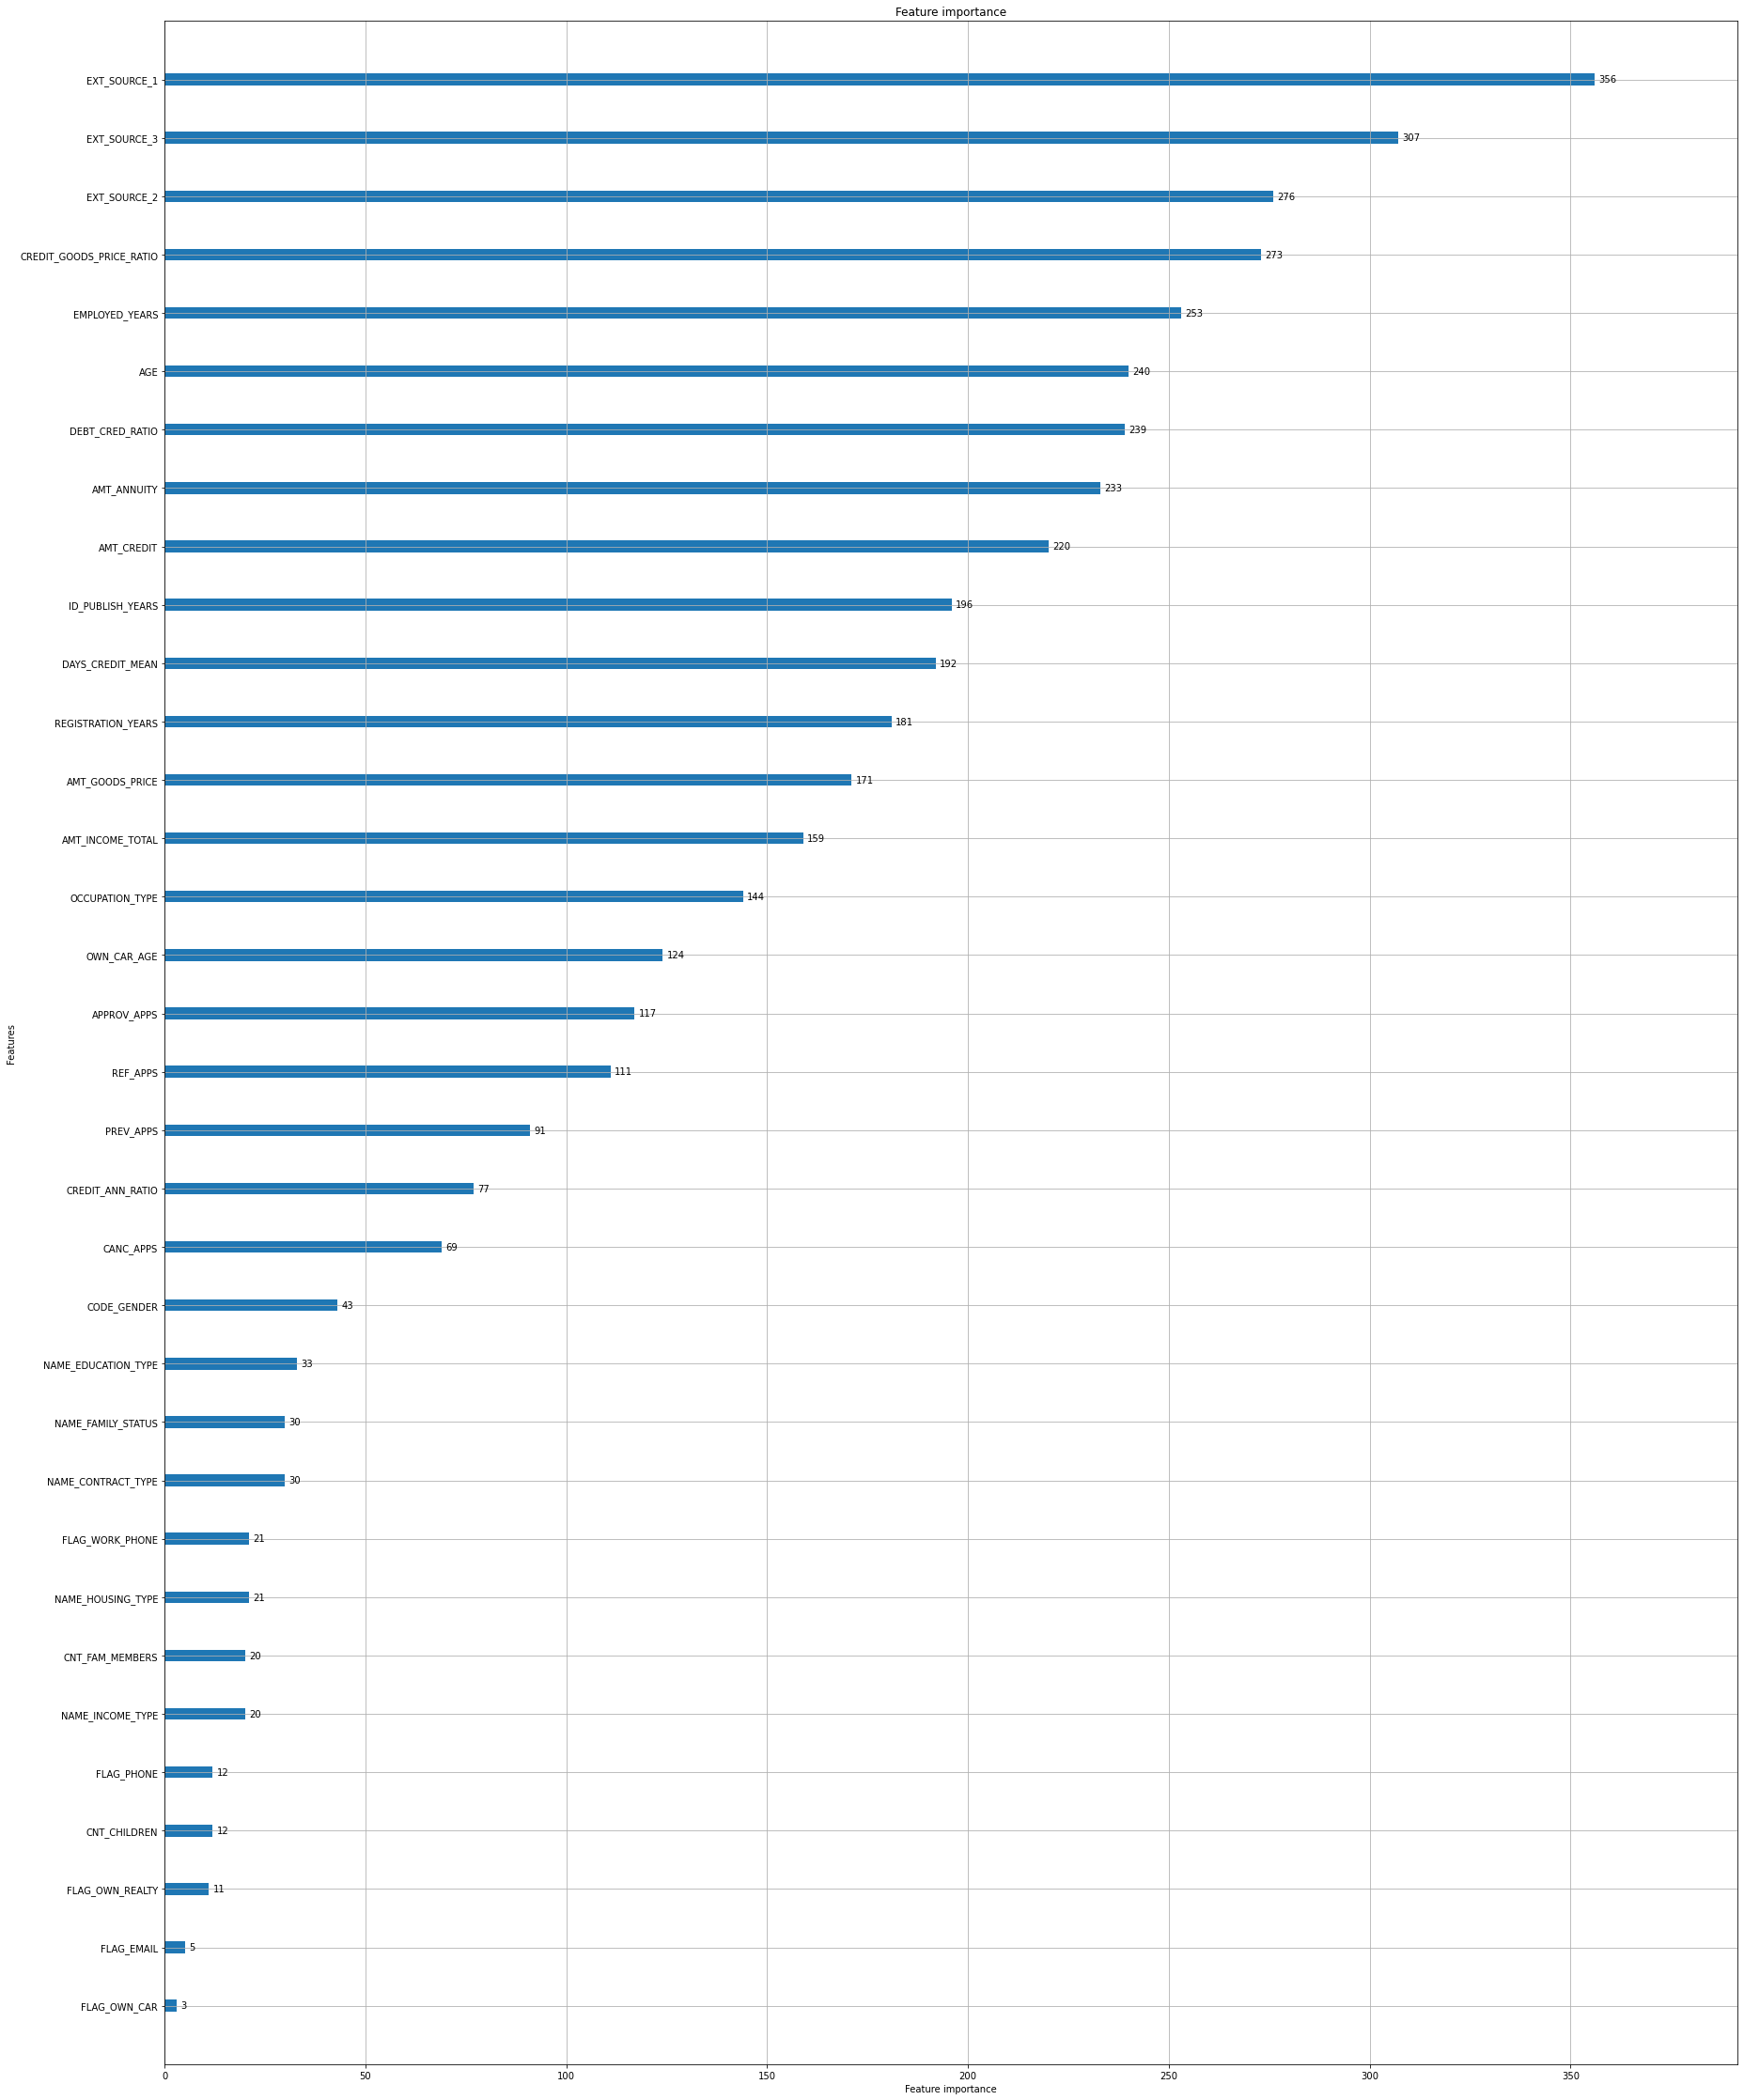

In [48]:
lgbm.plot_importance(lgbm_clf,figsize=(30,40))

In [49]:
#final_application_df=application_df.drop(['SK_ID_CURR','CODE_GENDER', 'NAME_EDUCATION_TYPE','CREDIT_ANN_RATIO','NAME_FAMILY_STATUS',
#"NAME_CONTRACT_TYPE','PREV_APPS','CANC_APPS','NAME_INCOME_TYPE','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
#                                         'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','FLAG_OWN_CAR','FLAG_OWN_REALTY'],axis=1)

In [50]:
X , y = final_application_df.drop('TARGET',axis=1), final_application_df[['TARGET']].values.flatten()

In [57]:
cat_features = X.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [X.columns.get_loc(col) for col in cat_features]

#convert cat_features to pd.Categorical dtype
for col in cat_features:
    X[col] = pd.Categorical(X[col])
    
#Splitting Unencoded train/test sets
X_train, X_eval, y_train, y_eval = train_test_split(X,y,test_size=0.2,random_state=1121218,stratify=y)
eval_set=[(X_eval, y_eval)]

N_SPLITS = 7
strat_kf = StratifiedKFold(n_splits=N_SPLITS,shuffle=True,random_state=1121218)
scores = np.empty(N_SPLITS)
for idx, (train_idx,test_idx) in enumerate (strat_kf.split(X,y)):
    print("=" * 12 + f"Training fold {idx+1}" + 12 * "=")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val = y[train_idx],y[test_idx]
    eval_set= [(X_val,y_val),(X_train,y_train)]    
    
    lgbm_clf = lgbm.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                class_weight = 'balanced', learning_rate = 0.05, 
                                reg_alpha = 0.1, reg_lambda = 0.1, 
                                subsample = 0.8, random_state = 1121218, feature_fraction = 0.3,
                                early_stopping_rounds = 30, num_leaves = 128, max_depth = 7)
        
    # Train the model
    lgbm_clf.fit(X_train, y_train, eval_metric = 'auc',
              eval_set = eval_set,
              eval_names = ['valid', 'train'], categorical_feature = cat_idx,
              early_stopping_rounds = 100, verbose = 200)
    
    best_iteration=lgbm_clf.best_iteration_
    preds=lgbm_clf.predict_proba(X_val, num_iteration = best_iteration)[:, 1]
    #print(preds.shape)
    #print(y_val.shape)
    roc_auc_score=metrics.roc_auc_score(y_val,preds)
    scores[idx]=roc_auc_score
    scores

============Training fold 1============
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=100
[200]	train's auc: 0.834506	train's binary_logloss: 0.515724	valid's auc: 0.770729	valid's binary_logloss: 0.53654
============Training fold 2============
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=100
[200]	train's auc: 0.835552	train's binary_logloss: 0.514278	valid's auc: 0.762126	valid's binary_logloss: 0.541018
============Training fold 3============
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[Ligh

In [58]:
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_val, preds)

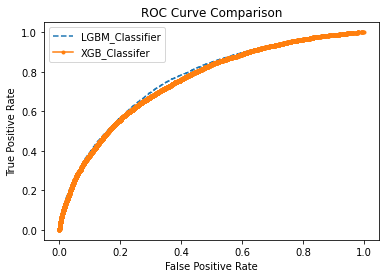

In [81]:
plt.plot(lgbm_fpr, lgbm_tpr, linestyle='--', label='LGBM_Classifier')
plt.plot(XGB_fpr, XGB_tpr, marker='.', label='XGB_Classifer')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [61]:
metrics.precision_recall_curve(y_val, preds)

(array([0.08071933, 0.08072116, 0.080723  , ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        5.64015792e-04, 2.82007896e-04, 0.00000000e+00]),
 array([0.00944571, 0.01092431, 0.01153029, ..., 0.94388263, 0.95446254,
        0.95447889]))

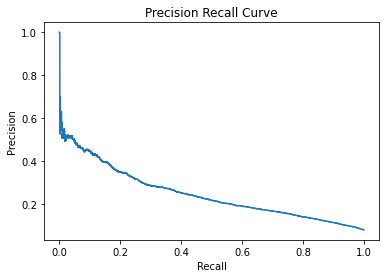

In [67]:
#Precision Recall Curve
precision, recall, thresholds = metrics.precision_recall_curve(y_val, preds)
pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision Recall Curve')
plt.show()